In [59]:
import numpy as np
from skimage import io
from skimage.feature import graycomatrix, graycoprops
import math
import pandas as pd
from matplotlib import pyplot as plt

In [60]:
happy = ['0105', '0107', '0110']
neutral = ['0101', '0106', '0109']
sad = ['0106', '0107', '0110']

selected = {
    'happy': happy,
    'neutral': neutral,
    'sad': sad
}

In [48]:
def create_pixel_matrix(emotion: str, number_images: list) -> list:
        return io.imread(f'datasets/{emotion}/{emotion}-{number_images}.jpg', as_gray = True)

In [49]:
def show_histogram(title: str, image_pixel: list):
        plt.subplot(1, 2, 1)
        plt.imshow(image_pixel, cmap = 'gray')
        plt.title(title)
        
        plt.subplot(1, 2, 2)
        plt.hist(image_pixel.ravel(), 256, [0, 255])
        plt.title(f'{title} histogram')

        plt.show()

In [55]:
def first_order_statistics(image_pixel: list) -> tuple:
    hist, _ = np.histogram(image_pixel, 256, [0, 255])

    # mean
    # print(np.mean(image_pixel))
    hist_sum = sum(hist)
    hist_per_sum = []
    mean = 0
    for h in hist:
        hist_per_sum.append(h / hist_sum)
    for i in range(256):
        mean += hist_per_sum[i] * i

    # print(mean)

    # variance
    # print(np.var(image_pixel))
    variance = 0
    for i in range(256):
        variance += (i - mean) ** 2 * hist_per_sum[i]
    # print(variance)

    # skewness
    skewness = 0
    for i in range(256):
        skewness += (i - mean) ** 3 * hist_per_sum[i]
    skewness = skewness / (variance * math.sqrt(variance))
    # print(skewness)

    # kurtosis
    kurtosis = 0
    for i in range(256):
        kurtosis += (i - mean) ** 4 * hist_per_sum[i]
    kurtosis = kurtosis / (variance ** 2) - 3
    # print(kurtosis)

    # entropy
    entropy = 0
    for i in range(246):
        entropy += hist_per_sum[i] * math.log2(np.spacing(hist_per_sum[i]))
    entropy = -entropy
    # print(entropy)

    return (mean, variance, skewness, kurtosis, entropy)

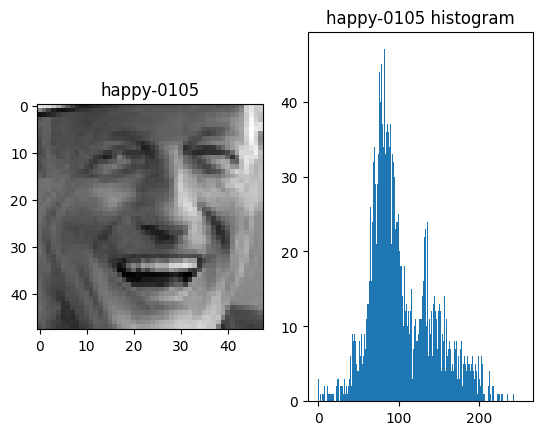

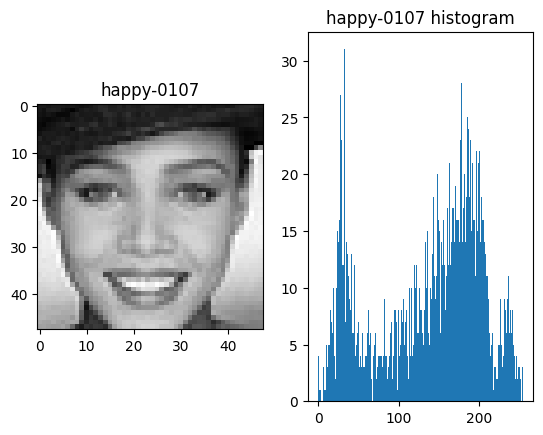

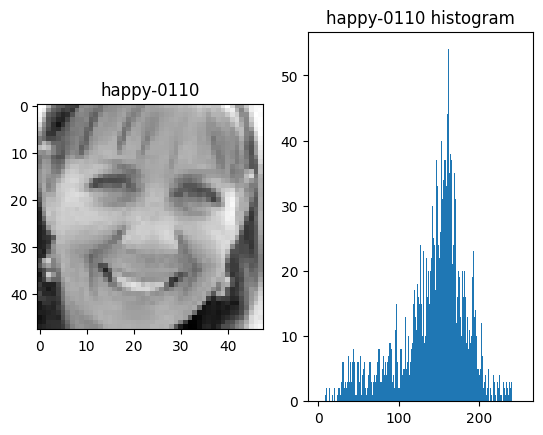

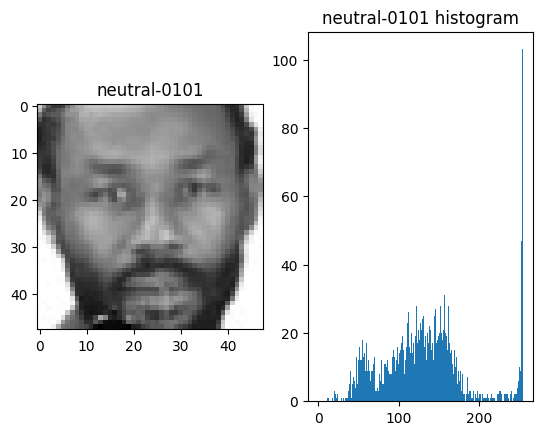

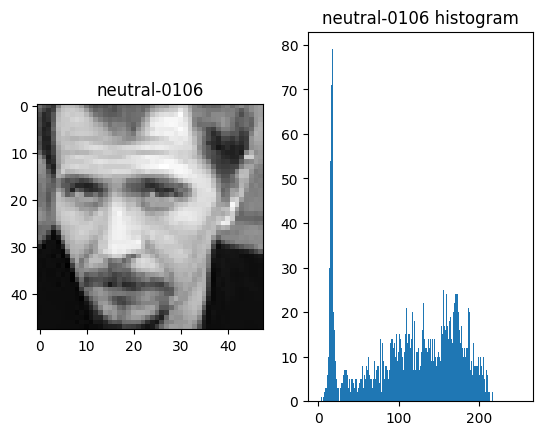

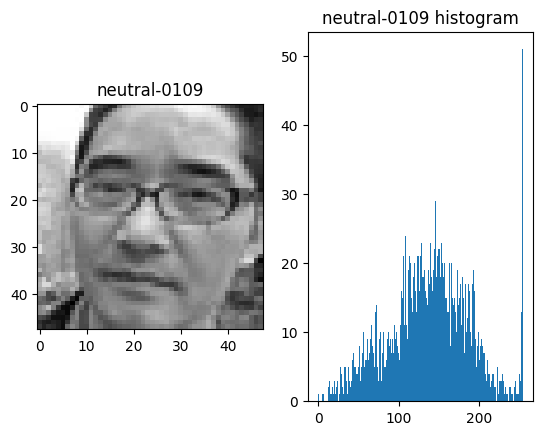

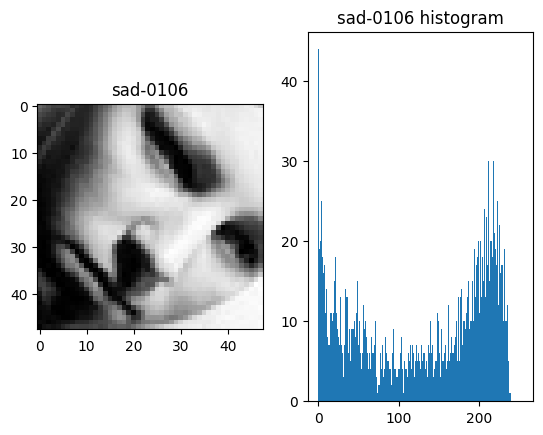

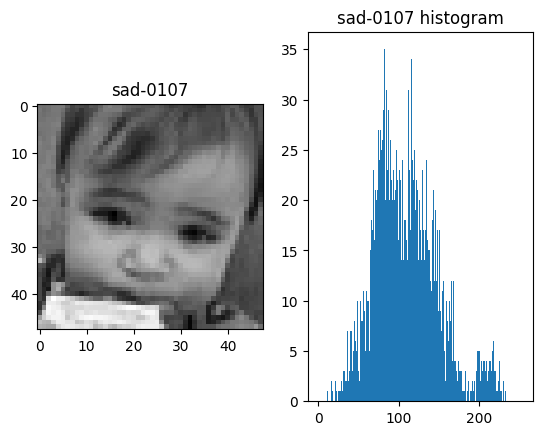

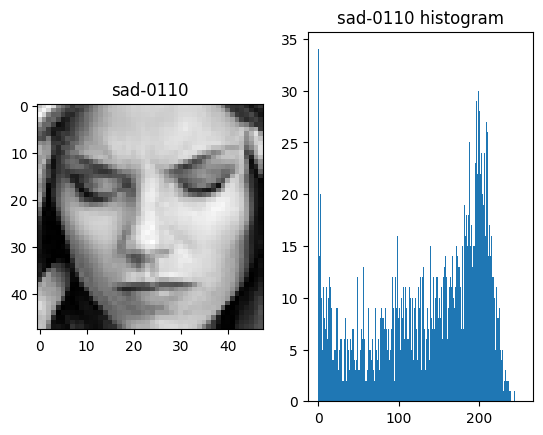

,mean,variance,skewness,kurtosis,entropy
happy-0105,102.976128,1664.550211,0.711753,0.234202,59.605035
happy-0107,137.716146,4503.797031,-0.456291,-1.006152,59.449653
happy-0110,143.888889,1773.740258,-0.832728,0.621634,59.645833
neutral-0101,133.392795,3082.416459,0.561167,0.055018,54.337240
neutral-0106,113.670573,3548.825940,-0.346698,-1.086451,59.845920
neutral-0109,138.642361,2684.830428,-0.014746,-0.175937,57.699653
sad-0106,127.677951,6513.115035,-0.247535,-1.490324,60.070312
sad-0107,110.358941,1643.385484,0.596771,0.268335,59.696181
sad-0110,135.783854,4707.169427,-0.552018,-0.959757,60.106771


In [81]:
first_statistics = []
image_label = []
for emotion in ['happy', 'neutral', 'sad']:
    for e in selected[emotion]:
        image_label.append(f'{emotion}-{e}')
        image_pixel = create_pixel_matrix(emotion, e)
        show_histogram(f'{emotion}-{e}', image_pixel)
        first_statistics.append(first_order_statistics(image_pixel))

test = pd.DataFrame(first_statistics, columns=['mean', 'variance', 'skewness', 'kurtosis', 'entropy'], index=image_label)
test

In [8]:
def glcm_calculation(pixel_image, dist = [5], angles = [0, np.pi / 4, np.pi / 3, 3 * np.pi / 4], level = 256, sym = True, norm = True):
    glcm = graycomatrix(pixel_image,
                        distances = dist,
                        angles = angles,
                        symmetric = sym,
                        normed = norm)
    return glcm

In [15]:
def glcm_features(glcm_matrix, props):
    features = []
    glcm_props = [property for name in props for property in graycoprops(glcm_matrix, name)[0]]
    for item in glcm_props:
        features.append(item)
    
    return features

In [40]:
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
glcm_all_agls = []
glcm_all_agls.append(glcm_features(glcm_matrix, properties))

columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)
        
# columns.append("label")
columns


['dissimilarity_0',
 'dissimilarity_45',
 'dissimilarity_90',
 'dissimilarity_135',
 'correlation_0',
 'correlation_45',
 'correlation_90',
 'correlation_135',
 'homogeneity_0',
 'homogeneity_45',
 'homogeneity_90',
 'homogeneity_135',
 'contrast_0',
 'contrast_45',
 'contrast_90',
 'contrast_135',
 'ASM_0',
 'ASM_45',
 'ASM_90',
 'ASM_135',
 'energy_0',
 'energy_45',
 'energy_90',
 'energy_135']

In [41]:

import pandas as pd 

# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls, 
                      columns = columns)

glcm_df

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,...,contrast_90,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135
0,10.738918,15.094613,15.094613,15.987325,0.918852,0.815432,0.815432,0.816304,0.124583,0.101686,...,602.516976,599.168855,0.000511,0.000462,0.000462,0.000443,0.022606,0.021492,0.021492,0.021037
